In [1]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/utils")
import NeuGNN_model
import Self_func
import Interaction_func
from NeuGNN_model import *
from Self_func import *
from Interaction_func import *

In [3]:
USE_CUDA = False

In [4]:
Timeseries = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/HR_stochastic_intensity01_10I.csv',encoding='utf-8',header=None)

In [5]:
Adj = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/unweighted_adj_20nodes.csv',encoding='utf-8',header=None)

In [6]:
Type = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/manuscript_code/Code/Data/Topology/edge_type_10I.csv',encoding='utf-8',header=None)

In [7]:
Type = Type.values.reshape((-1,1))
Type = torch.from_numpy(Type)

In [8]:
model = 'HR'

In [9]:
Adj.shape[0]

20

In [10]:
Num_nodes = 20
Dimension = 3

In [11]:
time = Timeseries.values
timeseries = time.reshape(( -1, Num_nodes, Dimension)) # checked, correct input data

In [12]:
delt_t = 0.01

In [13]:
timeseries_t0 = timeseries[:-2,:,:]
timeseries_t1 = timeseries[1:-1,:,:]
dX = (timeseries_t1-timeseries_t0)
dXdt = (timeseries_t1-timeseries_t0)/delt_t

In [14]:
data = np.concatenate((timeseries[:-2,:,:],dXdt),axis=2)

In [15]:
import numpy as np
def get_edge_index(Adj):
    num_nodes = Adj.shape[0]
    Adj = Adj.values
    edge_index = torch.from_numpy(np.array(np.where(Adj)))
    return edge_index

In [16]:
edge_index = get_edge_index(Adj) #target to source

index = [1,0]
edge_index = edge_index[index] #source to target 
# checked, correct input edge_index data

In [17]:
#edge_index

In [18]:
#Type

In [19]:
#data = data.reshape((10,-1,4,6))
import numpy as np
#goal_data = np.concatenate((data[1:-1,:,0:Dimension],data[0:-2,:,Dimension:Dimension*2]),axis=2)
goal_data = data[1:-1,:,0:Dimension]
mapping_data = data[0:-2,:,0:Dimension]

In [20]:
#tmp1 = np.concatenate([mapping_data[:, i] for i in range(0, mapping_data.shape[1], 1)])
#tmp2 = np.concatenate([goal_data[:, i] for i in range(0, goal_data.shape[1], 1)])
#X = torch.from_numpy(mapping_data)
#y = torch.from_numpy(goal_data)

X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [23]:
import torch
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing

In [24]:
aggr = 'add'
hidden = 100


msg_dim = 1
n_f = mapping_data.shape[2]

In [25]:
dim = Dimension*1

In [26]:
from torch_geometric.data import Data, DataLoader

In [27]:
class SDIdifftype(MessagePassing):
    def __init__(self, model, n_f, msg_dim, ndim, delt_t, Type, hidden=50, aggr='add', flow='source_to_target'):

        """If flow is 'source_to_target', the relation is (j,i), means information is passed from x_j to x_i'"""
        super(SDIdifftype, self).__init__(aggr=aggr, flow=flow)
        self.msg_fnc_excit = Seq(
            Lin(2,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,msg_dim)
        )
        for layer in self.msg_fnc_excit:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)
        
        self.msg_fnc_inh = Seq(
            Lin(2,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,msg_dim)
        )
        for layer in self.msg_fnc_inh:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std = 1e-1)

        

        self.node_fnc_x = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
        )
        for layer in self.node_fnc_x:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-1)
        
        self.node_fnc_y = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
        )
        for layer in self.node_fnc_y:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-1)
        
        self.node_fnc_z = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1)
        )
        if model == 'HR':
            for layer in self.node_fnc_z:
                if isinstance(layer,nn.Linear):
                    param_shape = layer.weight.shape
                    torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)
        else:
            for layer in self.node_fnc_z:
                if isinstance(layer,nn.Linear):
                    param_shape = layer.weight.shape
                    torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-1)
        
        self.stochastic_x = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_x:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)
        
        self.stochastic_y = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_y:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)

        
        self.stochastic_z = Seq(
            Lin(n_f,hidden),
            ReLU(),
            Lin(hidden,1),
            Softplus()
        )
        for layer in self.stochastic_z:
            if isinstance(layer,nn.Linear):
                param_shape = layer.weight.shape
                torch.nn.init.normal_(layer.weight, mean=0.0, std=1e-3)

    def forward(self, x, edge_index):
        # x has shape [N, number_of_features]
        # edge_index has shape [2,E]
        x = x
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):

        tmp = torch.cat([x_i[:,0], x_j[:,0]])
        tmp = tmp.reshape(2,-1)
        tmp = tmp.t()
        Len = int(x_j[:,0].shape[0])/int(self.Type.shape[0])
        T = self.Type.repeat(int(Len),1)
        T = T.clone().detach()
        Message_excit = self.msg_fnc_excit(tmp)
        Message_inh = self.msg_fnc_inh(tmp)

        #indexs = np.argwhere(T.numpy()<0)
        T_excit = torch.where(T>0,T,0)
        T_inh = torch.where(T<0,-T,0)
        #for i in range(indexs.shape[0]):
        Message = Message_excit*T_excit+Message_inh*T_inh
            
        #Message = np.zeros((T.shape[0],1))
        #Message = torch.tensor(Message)
        #for i in range(T.shape[0]):
            #if T[i]>0:
                #message_tmp = self.msg_fnc_excit(tmp[i,:])
            #else:
                #message_tmp = self.msg_fnc_inh(tmp[i,:])
            #Message[i] = message_tmp
        return Message
    

    def update(self, aggr_out, x=None):
        if self.ndim==1:
            fx = self.node_fnc_x(x)
            dxdt = fx+aggr_out
            x_update = x+dxdt*self.delt_t
            x_mean = x+dxdt*self.delt_t
            x_var = self.stochastic_x(x)
            return torch.distributions.Normal(x_mean, x_var),x_update
        elif self.ndim==2:
            fx = self.node_fnc_x(x)
            fy = self.node_fnc_y(x)
            dxdt = fx+aggr_out
            dydt = fy
            x_update = x[:,0].reshape(-1,1)+dxdt*self.delt_t
            y_update = x[:,1].reshape(-1,1)+dydt*self.delt_t
            x_mean = x[:,0].reshape(-1,1)+dxdt*self.delt_t
            y_mean = x[:,1].reshape(-1,1)+dydt*self.delt_t
            x_var = self.stochastic_x(x)
            y_var = self.stochastic_y(x)
            return torch.distributions.Normal(x_mean, x_var),torch.distributions.Normal(y_mean, y_var),x_update,y_update
        elif self.ndim==3:
            fx = self.node_fnc_x(x)
            fy = self.node_fnc_y(x)
            fz = self.node_fnc_z(x)
            dxdt = fx+aggr_out
            dydt = fy
            dzdt = fz
            x_update = x[:,0].reshape(-1,1)+dxdt*self.delt_t
            y_update = x[:,1].reshape(-1,1)+dydt*self.delt_t
            z_update = x[:,2].reshape(-1,1)+dzdt*self.delt_t
            x_mean = x[:,0].reshape(-1,1)+dxdt*self.delt_t
            y_mean = x[:,1].reshape(-1,1)+dydt*self.delt_t
            z_mean = x[:,2].reshape(-1,1)+dzdt*self.delt_t
            x_var = self.stochastic_x(x)
            y_var = self.stochastic_y(x)
            z_var = self.stochastic_z(x)
            return torch.distributions.Normal(x_mean, x_var),torch.distributions.Normal(y_mean, y_var),torch.distributions.Normal(z_mean, z_var),x_update,y_update,z_update


class SDI_Difftype(SDIdifftype):
     def __init__(
 		self, model, n_f, msg_dim, ndim, delt_t,Type,
 		edge_index, aggr='add', hidden=50, nt=1):
            super(SDI_Difftype, self).__init__(model, n_f, msg_dim, ndim, delt_t, Type, hidden=hidden, aggr=aggr)
            self.delt_t = delt_t
            self.nt = nt
            self.edge_index = edge_index
            self.ndim = ndim
            self.Type = Type
    
     def SDI_weighted(self, g, augment=False, augmentation=3):
            #x is [n, n_f]f
            x = g.x
            ndim = self.ndim
            if augment:
                augmentation = torch.randn(1, ndim)*augmentation
                augmentation = augmentation.repeat(len(x), 1).to(x.device)
                x = x.index_add(1, torch.arange(ndim).to(x.device), augmentation)
        
            edge_index = g.edge_index
            return self.propagate(
                    edge_index, size=(x.size(0), x.size(0)),
                    x=x)

     def loss(self, g, **kwargs):
            if self.ndim==1:
                out_dist,xUpdate = self.SDI_weighted(g)
                neg_log_likelihood = -out_dist.log_prob(g.y)
                return torch.sum(neg_log_likelihood)
            if self.ndim==2:
                out_dist_x,out_dist_y,xUpdate,yUpdate = self.SDI_weighted(g)
                neg_log_likelihood_x = -out_dist_x.log_prob(g.y[:,0].reshape(-1,1))
                neg_log_likelihood_y = -out_dist_y.log_prob(g.y[:,1].reshape(-1,1))
                return torch.sum(neg_log_likelihood_x)+torch.sum(neg_log_likelihood_y)
            if self.ndim==3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,yUpdate,zUpdate = self.SDI_weighted(g)
                neg_log_likelihood_x = -out_dist_x.log_prob(g.y[:,0].reshape(-1,1))
                neg_log_likelihood_y = -out_dist_y.log_prob(g.y[:,1].reshape(-1,1))
                neg_log_likelihood_z = -out_dist_z.log_prob(g.y[:,2].reshape(-1,1))
                return torch.mean(neg_log_likelihood_x)+torch.mean(neg_log_likelihood_y)+torch.mean(neg_log_likelihood_z)
     def sample_trajectories(self, g, **kwargs):
            if self.ndim == 1:
                out_dist,xUpdate = self.SDI_weighted(g)
                xUpdate_sample = out_dist.sample()
                return xUpdate_sample
            if self.ndim == 2:
                out_dist_x,out_dist_y,xUpdate,yUpdate = self.SDI_weighted(g)
                xUpdate_sample = out_dist_x.sample()
                yUpdate_sample = out_dist_y.sample()
                return xUpdate_sample, yUpdate_sample
            if self.ndim == 3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,yUpdate,zUpdate = self.SDI_weighted(g)
                xUpdate_sample = out_dist_x.sample()
                yUpdate_sample = out_dist_y.sample()
                zUpdate_sample = out_dist_z.sample()
                return xUpdate_sample, yUpdate_sample, zUpdate_sample

     def average_trajectories(self, g, **kwargs):
            if self.ndim == 1:
                out_dist,xUpdate = self.SDI_weighted(g)
                return xUpdate
            if self.ndim == 2:
                out_dist_x,out_dist_y,xUpdate,yUpdate = self.SDI_weighted(g)
                return xUpdate, yUpdate
            if self.ndim == 3:
                out_dist_x,out_dist_y,out_dist_z,xUpdate,yUpdate,zUpdate = self.SDI_weighted(g)
                return xUpdate, yUpdate, zUpdate

In [28]:
ogn = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, Type, hidden=hidden, edge_index=edge_index , aggr=aggr)

In [29]:
messages_over_time = []
selfDyn_over_time = []
diffusion_over_time = []
ogn = ogn

In [30]:
x=X_train[1]
y=y_train[1]
_q = Data(
    x=X_train[1],
    edge_index=edge_index,
    y=y_train[1])

In [31]:
ogn.loss(_q)

tensor(1.6473, grad_fn=<AddBackward0>)

In [32]:
batch = 32
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=64,
    shuffle=True
)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [33]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [35]:
init_lr = 5e-4

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

# total_epochs = 200
total_epochs = 50

batch_per_epoch = 2000

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=batch_per_epoch,#len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)

batch_per_epoch

2000

In [36]:
epoch = 0
from tqdm import tqdm

In [37]:
import numpy as onp
onp.random.seed(0)
test_idxes = onp.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
     [Data(
         X_test[i],
         edge_index=edge_index,
         y=y_test[i]) for i in test_idxes],
     batch_size=len(X_test),
     shuffle=False
 )

# newtestloader = DataLoader(
#     [Data(
#         X_train[i],
#         edge_index=edge_index,
#         y=y_train[i]) for i in test_idxes],
#     batch_size=len(X_train),
#     shuffle=False
# )

In [38]:
test_idxes.shape

(1000,)

In [39]:
import numpy as onp
import pandas as pd

def get_messages(ogn):

    def get_message_info(tmp):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]] #source
        s1 = s1[:,0]
        #print(s1)
        s2 = tmp.x[tmp.edge_index[1]] #target
        s2 = s2[:,0]
        #print(s2)
        Tmp = torch.cat([s2, s1]) # tmp --> xi,xj
        Tmp = Tmp.reshape(2,-1)
        Tmp = Tmp.t()# tmp has shape [E, 2 * in_channels]
        Len = int(s1.shape[0])/int(Type.shape[0])
        T = Type.repeat(int(Len),1)
        
        T_excit = torch.where(T>0,T,0)
        T_inh = torch.where(T<0,-T,0)
        #print(T_excit)
        #print(T_inh)
        #for i in range(indexs.shape[0]):
        tmpT = torch.cat([Tmp,T],dim=1)
        tmpT = tmpT.to(torch.float32)
        
        m12_excit = ogn.msg_fnc_excit(Tmp)
        m12_inh = ogn.msg_fnc_inh(Tmp)
        m12 = m12_excit*T_excit+m12_inh*T_inh
        #m12 = m12_excit*T+m12_inh*T
        #indexs = np.argwhere(T.numpy()<0)
        #for i in range(indexs.shape[0]):
            #m12[indexs[i][0]] = m12_inh[indexs[i][0]]
            
        #m12 = np.zeros((T.shape[0],1))
        #m12 = torch.tensor(m12)
        #for i in range(T.shape[0]):
            #if T[i]>0:
                #message_tmp = ogn.msg_fnc_excit(Tmp[i,:])
            #else:
                #message_tmp = ogn.msg_fnc_inh(Tmp[i,:])
            #m12[i] = message_tmp
        

        all_messages = torch.cat((
            tmpT,
             m12), dim=1)
        if dim == 1:
            columns = [elem%(k) for k in range(1,3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        if dim == 2:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['e%d'%(k,) for k in range(msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d'.split(' ')]
            columns += ['T']
            columns += ['e%d'%(k,) for k in range(msg_dim)]

        return pd.DataFrame(
              data=all_messages.cpu().detach().numpy(),
             columns=columns
        )
        #print(all_messages.shape)
        return pd.DataFrame(all_messages)

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g))

    msg_info = pd.concat(msg_info)
    
    return msg_info

In [40]:
def get_selfDynamics(ogn):
    def get_selfDynamics_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x), dim=1)
            columns = ['x','s1']
            
        if dim==2:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y), dim=1)
            columns = ['x','y','s1','s2']
        if dim==3:
            self_dyn_x = ogn.node_fnc_x(tmp)
            self_dyn_y = ogn.node_fnc_y(tmp)
            self_dyn_z = ogn.node_fnc_z(tmp)
            self_dyn_all = torch.cat((tmp,self_dyn_x,self_dyn_y,self_dyn_z), dim=1)
            columns = ['x','y','z','s1','s2','s3']
            
        return pd.DataFrame(
              data=self_dyn_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_dyn_all)

    selfDyn_info = []
    for i, g in enumerate(newtestloader):
        selfDyn_info.append(get_selfDynamics_info(g))

    selfDyn_info = pd.concat(selfDyn_info)
    return selfDyn_info        

In [41]:
def get_diffusion(ogn):
    def get_diffusion_info(tmp):
        ogn.cpu()
        
        tmp = tmp.x[tmp.edge_index[1]]
        if dim==1:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x), dim=1)
            columns = ['x','d1']
            
        if dim==2:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y), dim=1)
            columns = ['x','y','d1','d2']
        if dim==3:
            self_diff_x = ogn.stochastic_x(tmp)
            self_diff_y = ogn.stochastic_y(tmp)
            self_diff_z = ogn.stochastic_z(tmp)
            self_diff_all = torch.cat((tmp,self_diff_x,self_diff_y,self_diff_z), dim=1)
            columns = ['x','y','z','d1','d2','d3']
            
        return pd.DataFrame(
              data=self_diff_all.cpu().detach().numpy(),
             columns=columns
        )
        return pd.DataFrame(self_diff_all)

    selfDiffusion_info = []
    for i, g in enumerate(newtestloader):
        selfDiffusion_info.append(get_diffusion_info(g))

    selfDiffusion_info = pd.concat(selfDiffusion_info)
    return selfDiffusion_info 

In [42]:
recorded_models = []

In [43]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn
    total_loss = 0.0
    i = 0
    j = 0
    num_items = 0
    valid_loss = 0
    valid_num_items = 0
    while i < batch_per_epoch:
        for ginput in trainloader:
            if i >= batch_per_epoch:
                break
            opt.zero_grad()
            ginput.x = ginput.x
            ginput.y = ginput.y
            ginput.edge_index = ginput.edge_index
            ginput.batch = ginput.batch
            loss = ogn.loss(ginput)
            loss.backward()
            opt.step()
            sched.step()

            total_loss += loss.item()
            i += 1
            num_items += int(ginput.batch[-1]+1)
    
    ogn.eval()
    with torch.no_grad():
        while j < batch_per_epoch:
            for ginput in testloader:
                if j>= batch_per_epoch:
                    break
                ginput.x = ginput.x
                ginput.y = ginput.y
                ginput.edge_index = ginput.edge_index
                ginput.batch = ginput.batch
                loss = ogn.loss(ginput)#/int(ginput.batch[-1]+1)
                valid_loss += loss.item()
                valid_num_items += int(ginput.batch[-1]+1)
                j += 1



    cur_loss = total_loss/num_items
    cur_valid_loss = valid_loss/valid_num_items
    print(cur_loss)
    print(cur_valid_loss)
    cur_msgs = get_messages(ogn)
    cur_selfdyn = get_selfDynamics(ogn)
    cur_diff = get_diffusion(ogn)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = cur_loss
    messages_over_time.append(cur_msgs)
    selfDyn_over_time.append(cur_selfdyn)
    diffusion_over_time.append(cur_diff)
    
    ogn.cpu()
    from copy import deepcopy as copy
    recorded_models.append(copy(ogn.state_dict()))

  0%|                                                    | 0/50 [00:00<?, ?it/s]

0.00357054261503538
-0.02113633319765464


  2%|▊                                        | 1/50 [02:10<1:46:41, 130.64s/it]

-0.09854815713796403
-0.0837401214450044


  4%|█▋                                       | 2/50 [04:21<1:44:27, 130.57s/it]

-0.2016799186493029
-0.10731361613298768


  6%|██▍                                      | 3/50 [06:29<1:41:36, 129.72s/it]

-0.22440494314451498
-0.11034071048050895


  8%|███▎                                     | 4/50 [08:38<1:39:11, 129.37s/it]

-0.22781954182403777
-0.11095189027364741


 10%|████                                     | 5/50 [10:47<1:36:48, 129.07s/it]

-0.22862221038771627
-0.11101821613171063


 12%|████▉                                    | 6/50 [12:55<1:34:30, 128.88s/it]

-0.2287461361233189
-0.11090213654629254


 14%|█████▋                                   | 7/50 [15:04<1:32:16, 128.76s/it]

-0.22914228222210958
-0.11145934131743021


 16%|██████▌                                  | 8/50 [17:12<1:30:05, 128.70s/it]

-0.2301710420547691
-0.11168173673253512


 18%|███████▍                                 | 9/50 [19:21<1:27:55, 128.68s/it]

-0.23076747481088344
-0.11190150258290833


 20%|████████                                | 10/50 [21:30<1:25:45, 128.64s/it]

-0.23139155219323482
-0.1121908038076236


 22%|████████▊                               | 11/50 [23:38<1:23:36, 128.63s/it]

-0.23178222190328454
-0.11242528769432271


 24%|█████████▌                              | 12/50 [25:47<1:21:27, 128.62s/it]

-0.23194685415496866
-0.11241160300974269


 26%|██████████▍                             | 13/50 [27:55<1:19:17, 128.57s/it]

-0.2322909642560841
-0.11270804224991428


 28%|███████████▏                            | 14/50 [30:04<1:17:09, 128.59s/it]

-0.23261096849049162
-0.11281662197836914


 30%|████████████                            | 15/50 [32:12<1:14:58, 128.52s/it]

-0.2326691909356216
-0.11282626948109349


 32%|████████████▊                           | 16/50 [34:21<1:12:48, 128.48s/it]

-0.23279125548855284
-0.11271157616769052


 34%|█████████████▌                          | 17/50 [36:29<1:10:39, 128.46s/it]

-0.23297264226621406
-0.11286463590721459


 36%|██████████████▍                         | 18/50 [38:38<1:08:32, 128.52s/it]

-0.23310789227521048
-0.11298831895420385


 38%|███████████████▏                        | 19/50 [40:46<1:06:22, 128.48s/it]

-0.23318771637422822
-0.11290121511455638


 40%|████████████████                        | 20/50 [42:54<1:04:12, 128.42s/it]

-0.23304775739246258
-0.11298308375191893


 42%|████████████████▊                       | 21/50 [45:03<1:02:09, 128.61s/it]

-0.23327914168280076
-0.11307535042854364


 44%|██████████████████▍                       | 22/50 [47:11<59:56, 128.46s/it]

-0.23321140905707166
-0.11315136840674579


 46%|███████████████████▎                      | 23/50 [49:20<57:44, 128.33s/it]

-0.23328833243458588
-0.11313625760769377


 48%|████████████████████▏                     | 24/50 [51:28<55:34, 128.24s/it]

-0.2333401612740583
-0.11317452077348289


 50%|█████████████████████                     | 25/50 [53:36<53:24, 128.19s/it]

-0.23343675230485134
-0.11315008988187637


 52%|█████████████████████▊                    | 26/50 [55:44<51:15, 128.16s/it]

-0.23353683924487598
-0.11321416306007692


 54%|██████████████████████▋                   | 27/50 [57:54<49:20, 128.73s/it]

-0.23355278085950357
-0.11317583510305101


 56%|██████████████████████▍                 | 28/50 [1:00:08<47:50, 130.46s/it]

-0.23354112138367725
-0.11316199279247607


 58%|███████████████████████▏                | 29/50 [1:02:22<45:58, 131.33s/it]

-0.23358160858163834
-0.11316035123236032


 60%|████████████████████████                | 30/50 [1:04:32<43:41, 131.07s/it]

-0.23367360258988332
-0.11326132870046773


 62%|████████████████████████▊               | 31/50 [1:06:43<41:32, 131.16s/it]

-0.23364140377649395
-0.1132518765406654


 64%|█████████████████████████▌              | 32/50 [1:08:56<39:26, 131.50s/it]

-0.23367054925843445
-0.11311259224359742


 66%|██████████████████████████▍             | 33/50 [1:11:06<37:11, 131.25s/it]

-0.23370101216908706
-0.11322563775501199


 68%|███████████████████████████▏            | 34/50 [1:13:22<35:22, 132.67s/it]

-0.23383590000328489
-0.11332145888622175


 70%|████████████████████████████            | 35/50 [1:15:34<33:07, 132.47s/it]

-0.23382389673410395
-0.11328387791445242


 72%|████████████████████████████▊           | 36/50 [1:17:43<30:39, 131.38s/it]

-0.23385346326063985
-0.11331288076072767


 74%|█████████████████████████████▌          | 37/50 [1:19:51<28:15, 130.41s/it]

-0.23389157554176668
-0.11330308726629021


 76%|██████████████████████████████▍         | 38/50 [1:22:00<25:56, 129.74s/it]

-0.23383940746890872
-0.11326892943776834


 78%|███████████████████████████████▏        | 39/50 [1:24:08<23:41, 129.27s/it]

-0.23398978558510883
-0.11333962237263133


 80%|████████████████████████████████        | 40/50 [1:26:16<21:29, 128.92s/it]

-0.2339658867946436
-0.11335144303121619


 82%|████████████████████████████████▊       | 41/50 [1:28:24<19:18, 128.69s/it]

-0.23394688496390795
-0.11334304179994381


 84%|█████████████████████████████████▌      | 42/50 [1:30:32<17:08, 128.51s/it]

-0.2339081828746244
-0.11332092531837452


 86%|██████████████████████████████████▍     | 43/50 [1:32:40<14:58, 128.39s/it]

-0.23399570094538247
-0.11336450597214255


 88%|███████████████████████████████████▏    | 44/50 [1:34:48<12:49, 128.31s/it]

-0.23408379804280177
-0.11334007508802031


 90%|████████████████████████████████████    | 45/50 [1:36:57<10:42, 128.41s/it]

-0.23405595110891714
-0.11338184566982185


 92%|████████████████████████████████████▊   | 46/50 [1:39:05<08:33, 128.40s/it]

-0.23411638814922361
-0.11337126192736421


 94%|█████████████████████████████████████▌  | 47/50 [1:41:13<06:24, 128.32s/it]

-0.2340524534636189
-0.11338519032937926


 96%|██████████████████████████████████████▍ | 48/50 [1:43:22<04:16, 128.24s/it]

-0.23411374352363032
-0.11338221236112907


 98%|███████████████████████████████████████▏| 49/50 [1:45:30<02:08, 128.24s/it]

-0.23405541374785568
-0.1133788454920308


100%|████████████████████████████████████████| 50/50 [1:47:38<00:00, 129.17s/it]


In [44]:
diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

s = diffusion_new['d1']/np.sqrt(0.01) # diffusion is sqrt(h)*theta(x0) 
# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# #ax1.scatter(s.index, s.values)
# ax1.plot(s.index, s.values,'.')
# plt.grid()
 
# ax2 = fig.add_subplot(2,1,2) 
# s.hist(bins=30,alpha = 0.5,ax = ax2)
# s.plot(kind = 'kde', secondary_y=True,ax = ax2)
# plt.title('The standard deviation distribusion')
# plt.grid()

In [45]:
s1 = (diffusion['x'].abs())*0.1 # diffusion is sqrt(h)*theta(x0) 
# fig = plt.figure(figsize = (10,6))
# ax1 = fig.add_subplot(2,1,1)
# ax2 = fig.add_subplot(2,1,2) 
# s1.hist(bins=30,alpha = 0.5,ax = ax2)
# s1.plot(kind = 'kde', secondary_y=True,ax = ax2)
# plt.title('The standard deviation distribusion')
# plt.grid()

In [46]:
import seaborn as sns
import numpy as np
from numpy.random import randn
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
 
sns.set_palette('deep', desat=.6)
sns.set_context(rc={'figure.figsize': (8, 5) } )
np.random.seed(1425)

In [47]:
s2 = diffusion_new['d2']/np.sqrt(0.01)
s3 = (diffusion['y'].abs())*0.1 
s4 = diffusion_new['d3']/np.sqrt(0.01)
s5 = (diffusion['z'].abs())*0.1 

In [48]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

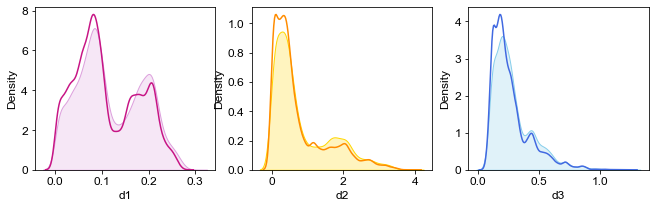

In [188]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(11, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.kdeplot(s, shade=True, color=colors['plum'], label='dist1', ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['gold'], label='dist1', ax=ax2)
sns.kdeplot(s4, shade=True, color=colors['skyblue'], label='dist1', ax=ax3)
sns.kdeplot(s1, shade=False, color=colors['mediumvioletred'], label='dist2',ax=ax1)
sns.kdeplot(s3, shade=False, color=colors['darkorange'], label='dist2',ax=ax2)
sns.kdeplot(s5, shade=False, color=colors['royalblue'], label='dist2',ax=ax3)

#plt.xlim([0, 1.5])
#plt.ylim([0, 0.11])
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_diffusion_fig.pdf')

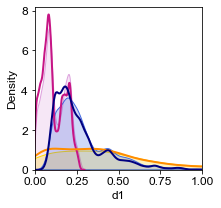

In [276]:
fig = plt.figure(figsize=(3, 3))
ax1 = fig.add_subplot(1,1,1)
c1, c2, c3 = sns.color_palette('Set1', 3)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

sns.kdeplot(s, shade=True, color=colors['plum'], label='dist1', ax=ax1,lw=1)
#sns.kdeplot(s1, shade=True, color=colors['plum'], label='dist2',ax=ax1)
sns.kdeplot(s2, shade=True, color=colors['gold'], label='dist1', ax=ax1,lw=1)
#sns.kdeplot(s3, shade=True, color=colors['mistyrose'], label='dist2',ax=ax1)
sns.kdeplot(s4, shade=True, color=colors['royalblue'], label='dist1', ax=ax1,lw=1)
#sns.kdeplot(s5, shade=True, color=colors['skyblue'], label='dist2',ax=ax1)

sns.kdeplot(s1, shade=False, color=colors['mediumvioletred'], label='dist2',ax=ax1,lw=2)
sns.kdeplot(s3, shade=False, color=colors['darkorange'], label='dist2',ax=ax1,lw=2)
sns.kdeplot(s5, shade=False, color=colors['navy'], label='dist2',ax=ax1,lw=2)
plt.xlim([0, 1])
#plt.ylim([0, 0.11])
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_diffusion_all.pdf')

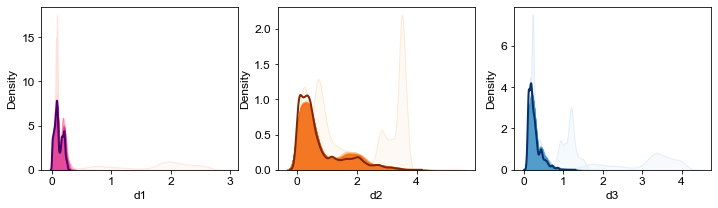

In [273]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(12, 3))
c1, c2, c3 = sns.color_palette('Set1', 3)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
cmap = mpl.cm.get_cmap("RdPu")
cmap1 = mpl.cm.get_cmap("Oranges")
cmap2 = mpl.cm.get_cmap("Blues")
for i in range(total_epochs):#total_epochs
    diffusion = diffusion_over_time[i]
    diffusion = pd.DataFrame(diffusion)
    diffusion_new = pd.DataFrame.drop_duplicates(diffusion, subset=None, keep='first', inplace=False)
    s = diffusion_new['d1']/np.sqrt(0.01)
    s2 = diffusion_new['d2']/np.sqrt(0.01)
    s3 = (diffusion['y'].abs())*0.1 
    s4 = diffusion_new['d3']/np.sqrt(0.01)
    s5 = (diffusion['z'].abs())*0.1
    sns.kdeplot(s, shade=True, color=cmap(np.linspace(0, 1, total_epochs*2))[i+10], label='dist1', ax=ax1,lw=1)
    sns.kdeplot(s2, shade=True, color=cmap1(np.linspace(0, 1, total_epochs*2))[i+10], label='dist1', ax=ax2,lw=1)
    sns.kdeplot(s4, shade=True, color=cmap2(np.linspace(0, 1, total_epochs*2))[i+10], label='dist1', ax=ax3,lw=1)
sns.kdeplot(s1, shade=False, color=cmap(np.linspace(0, 1, total_epochs*2))[-1], label='dist2',ax=ax1,lw=2)
sns.kdeplot(s3, shade=False, color=cmap1(np.linspace(0, 1, total_epochs*2))[-1], label='dist2',ax=ax2,lw=2)
sns.kdeplot(s5, shade=False, color=cmap2(np.linspace(0, 1, total_epochs*2))[-1], label='dist2',ax=ax3,lw=2)
#ax1.set_xlim([0,4])
#ax2.set_xlim([0,])
#ax3.set_xlim([0,2])
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_diffusion_epoch_50.pdf')

Text(0, 0.5, 'Inferred diffusion z')

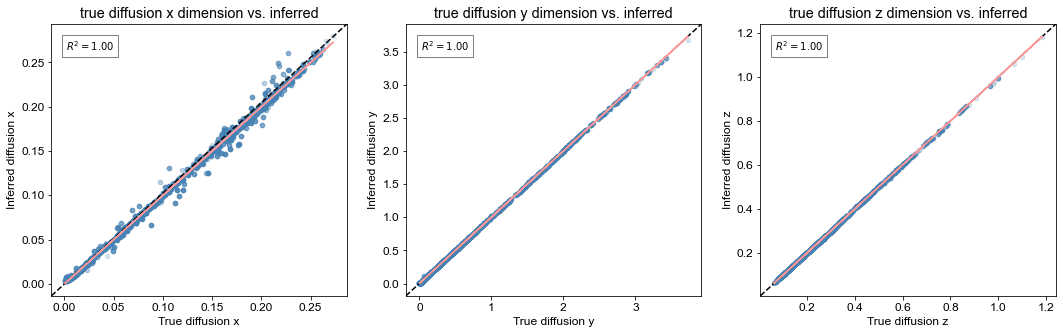

In [51]:
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})


diffusion = diffusion_over_time[-1]
diffusion = pd.DataFrame(diffusion)
sx = diffusion['d1'].values/np.sqrt(0.01)
sx_true = np.abs(diffusion['x'].values)*0.1
sy = diffusion['d2'].values/np.sqrt(0.01)
sy_true = np.abs(diffusion['y'])*0.1
sz = diffusion['d3'].values/np.sqrt(0.01)
sz_true = np.abs(diffusion['z'])*0.1

sx = sx[0:5000]
sx_true = sx_true[0:5000]
sy = sy[0:5000]
sy_true = sy_true[0:5000]
sz = sz[0:5000]
sz_true = sz_true[0:5000]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true diffusion x dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c = '#ff9999', lw=1.5)

ax1.scatter(sx_true,sx,s=20,c ='steelblue', alpha=0.2)
#sb.regplot(sx_true,sx, fit_reg = Fals,
           #x_jitter = 1e-5, y_jitter = 1e-5, scatter_kws = {'alpha' : 1/3})
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion x")
plt.ylabel("Inferred diffusion x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true diffusion y dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=20,c ='steelblue', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c = '#ff9999', lw=1.5)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion y")
plt.ylabel("Inferred diffusion y")

ax3 = fig.add_subplot(1,3,3)
plt.title("true diffusion z dimension vs. inferred")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=20,c ='steelblue', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fx(sz_true),c = '#ff9999', lw=1.5)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=10, bbox=bbox)
plt.xlabel("True diffusion z")
plt.ylabel("Inferred diffusion z")

In [261]:
ogn.cpu()
ogn.load_state_dict(recorded_models[18])

<All keys matched successfully>

In [262]:
X = torch.as_tensor(np.array(mapping_data).astype('float'))
y = torch.as_tensor(np.array(goal_data).astype('float'))
x_Update = []
y_Update = []
z_Update = []
for i in range(5000):#X.shape[0]
    _q = Data(
        x=X[i].float(),
        edge_index=edge_index,
        y=y[i].float())
    x_tmp, y_tmp, z_tmp = ogn.average_trajectories(_q)
    X_tmp = torch.cat((x_tmp,y_tmp,z_tmp), 1)
    if i < X.shape[0]-2:
        X[i+1] = X_tmp
    else:
        break
    x_Update.append(x_tmp.reshape(1,-1))
    y_Update.append(y_tmp.reshape(1,-1))
    z_Update.append(z_tmp.reshape(1,-1))   
x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)

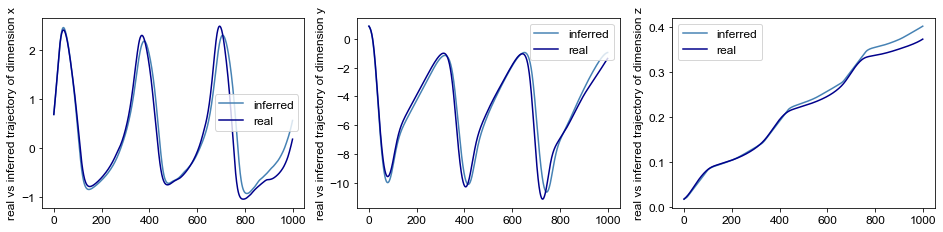

In [274]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/HR_determ_intensity01_10I.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
#plt.rcParams['savefig.dpi'] = 300 
#plt.rcParams['figure.dpi'] = 300
x_tra = x_i.detach().numpy()[0:1000,0]
x_real = time1.iloc[:,0]
fig = plt.figure(figsize=(16,3.5))
ax1 = fig.add_subplot(1,3,1)
t = np.arange(0,x_tra.shape[0])
ax1.plot(t,x_tra,c='steelblue',label="inferred")
ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension x')
plt.legend()

ax2 = fig.add_subplot(1,3,2)
y_tra = y_i.detach().numpy()[0:1000,0]
y_real = time1.iloc[:,1]
t = np.arange(0,y_tra.shape[0])
ax2.plot(t,y_tra,c='steelblue',label="inferred")
ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension y')
plt.legend()

ax3 = fig.add_subplot(1,3,3)
z_tra = z_i.detach().numpy()[0:1000,0]
z_real = time1.iloc[:,2]
t = np.arange(0,z_tra.shape[0])
ax3.plot(t,z_tra,c='steelblue',label="inferred")
ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real")
plt.ylabel('real vs inferred trajectory of dimension z')
plt.legend()
plt.savefig('/Users/lanag/OneDrive/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_trajectory.png')
#plt.show()
#plt.close()
#plt.savefig('HRtrajectory.pdf')

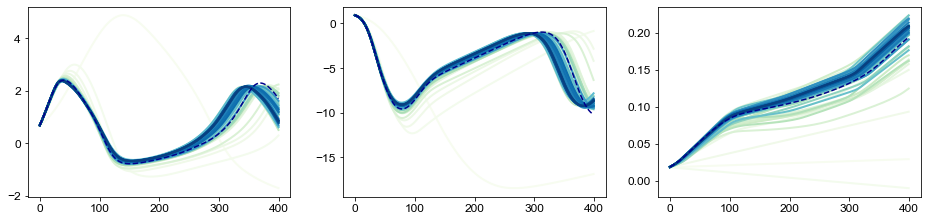

In [227]:
time1 = pd.read_csv('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/HR_determ_intensity01_10I.csv',encoding='utf-8',header=None)
plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
fig = plt.figure(figsize=(16,3.5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
cmap = mpl.cm.get_cmap("GnBu")
for j in range(total_epochs):
    ogn1 = SDI_Difftype(model,n_f, msg_dim, dim, delt_t, Type, hidden=hidden, edge_index=edge_index , aggr=aggr)
    ogn1.load_state_dict(recorded_models[j])
    X = torch.as_tensor(np.array(mapping_data).astype('float'))
    y = torch.as_tensor(np.array(goal_data).astype('float'))
    x_Update = []
    y_Update = []
    z_Update = []
    for i in range(500):#X.shape[0]
        _q = Data(
            x=X[i].float(),
            edge_index=edge_index,
            y=y[i].float())
        x_tmp, y_tmp, z_tmp = ogn1.average_trajectories(_q)
        X_tmp = torch.cat((x_tmp,y_tmp,z_tmp), 1)
        if i < X.shape[0]-2:
            X[i+1] = X_tmp
        else:
            break
        x_Update.append(x_tmp.reshape(1,-1))
        y_Update.append(y_tmp.reshape(1,-1))
        z_Update.append(z_tmp.reshape(1,-1))   
    x_i = torch.stack(x_Update, dim=0).reshape(-1,Num_nodes)
    y_i = torch.stack(y_Update, dim=0).reshape(-1,Num_nodes)
    z_i = torch.stack(z_Update, dim=0).reshape(-1,Num_nodes)
    x_tra = x_i.detach().numpy()[0:400,0]
    x_real = time1.iloc[:,0]

    t = np.arange(0,x_tra.shape[0])
    ax1.plot(t,x_tra,c=cmap(np.linspace(0, 1, total_epochs))[j],label="inferred",lw=2)
    #ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real")
    #plt.ylabel('real vs inferred trajectory of dimension x')
    #plt.legend()

    #ax2 = fig.add_subplot(1,3,2)
    y_tra = y_i.detach().numpy()[0:400,0]
    y_real = time1.iloc[:,1]
    t = np.arange(0,y_tra.shape[0])
    ax2.plot(t,y_tra,c=cmap(np.linspace(0, 1, total_epochs))[j],label="inferred",lw=2)
    #ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real")
    #plt.ylabel('real vs inferred trajectory of dimension y')
    #plt.legend()

    #ax3 = fig.add_subplot(1,3,3)
    z_tra = z_i.detach().numpy()[0:400,0]
    z_real = time1.iloc[:,2]
    t = np.arange(0,z_tra.shape[0])
    ax3.plot(t,z_tra,c=cmap(np.linspace(0, 1, total_epochs))[j],label="inferred",lw=2)
    #ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real")
    #plt.ylabel('real vs inferred trajectory of dimension z')
    #plt.legend()
ax1.plot(t, x_real[1:x_tra.shape[0]+1,],c='darkblue',label="real",linestyle='dashed')
ax2.plot(t, y_real[1:y_tra.shape[0]+1,],c='darkblue',label="real",linestyle='dashed')
ax3.plot(t, z_real[1:z_tra.shape[0]+1,],c='darkblue',label="real",linestyle='dashed')
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_traj_50epoch.pdf')

In [228]:
#cmap = mpl.cm.get_cmap("coolwarm")
#cmap

In [194]:
best_message = np.argmax([np.std(messages_over_time[-1]['e%d'%(i,)]) for i in range(msg_dim)])

In [200]:
bestMe = messages_over_time[-1][['e%d'%(best_message),'x1','x2','T']]

In [201]:
coup_value = 0.15*(2-bestMe['x1'].values)/(1+np.exp(-10*(bestMe['x2'].values-1))) # x1 (x_i) is target, x2 (x_j) is source 
coup_value_inh = 0.15*(-1.5-bestMe['x1'].values)/(1+np.exp(-10*(bestMe['x2'].values-1))) #np.sin(bestMe['x2'].values-bestMe['x1'].values)

In [202]:
# indexs = np.argwhere(bestMe['T'].values<0)
# for i in range(indexs.shape[0]):
#     #print(coup_value[indexs[i][0]],coup_value_inh[indexs[i][0]])
#     coup_value[indexs[i][0]] = coup_value_inh[indexs[i][0]]

In [203]:
T = bestMe['T'].values
T_excit = np.where(T>0,T,0)
T_inh = np.where(T<0,-T,0)

coup_value = coup_value*T_excit+coup_value_inh*T_inh

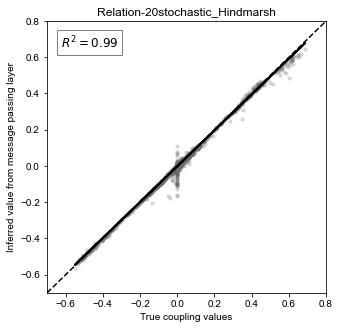

In [238]:
plt.rcParams.update({'font.size': 10}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
temp = bestMe.iloc[:,0].values
coup_value = coup_value[:10000]
temp = temp[:10000]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1,1,1)
ax.scatter(coup_value,temp,s=10,c ='dimgrey', alpha=0.2)
ax.plot((0, 1), (0, 1), transform=ax.transAxes, ls='--',c='k', label="1:1 line")
parameter = np.polyfit(coup_value,temp,1)
f = np.poly1d(parameter)
ax.plot(coup_value,f(coup_value),c = 'k', lw=2)
corr = np.corrcoef(coup_value,temp)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corr**2),transform=ax.transAxes, size=12, bbox=bbox)
plt.title('Relation-20stochastic_Hindmarsh')
plt.xlabel("True coupling values")
plt.ylabel("Inferred value from message passing layer")
plt.xlim([-0.7, 0.8])
plt.ylim([-0.7, 0.8])
plt.savefig('/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/HR_10I_coupling_dimgrey.pdf')


In [268]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

In [269]:
import random
R = random.sample(range(0,len(best_selfDyn['s2'])),5000) 

Text(0, 0.5, 'Inferred self z')

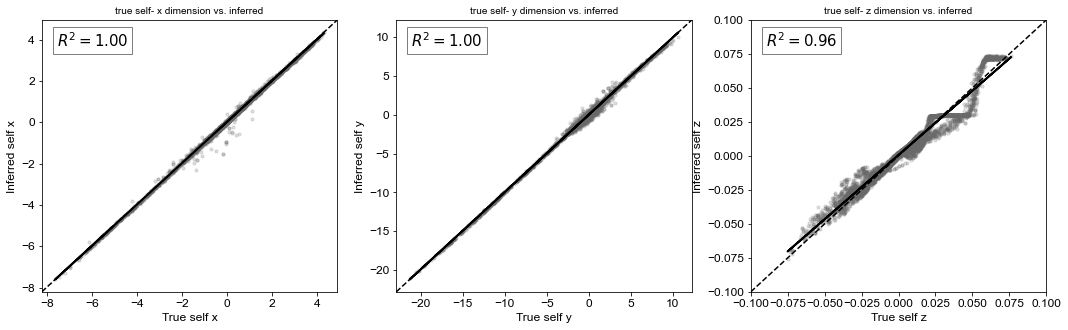

In [270]:
# gamma = 0.03
# sx = best_selfDyn['s1'].values
# sx_true = 10*best_selfDyn['y']-(10+2/gamma)*best_selfDyn['x']
# sy = best_selfDyn['s2'].values
# sy_true = (28-best_selfDyn['z'])*best_selfDyn['x']-(1+2/gamma)*best_selfDyn['y']
# sz = best_selfDyn['s3'].values
# sz_true = best_selfDyn['x']*best_selfDyn['y']-(8/3+4/gamma)*best_selfDyn['z']

plt.rcParams.update({'font.size': 12}) 
plt.rcParams.update({'font.style': 'normal'})
plt.rcParams.update({'font.family': 'Arial'})
sx = best_selfDyn['s1'].values
sx_true = best_selfDyn['y']-best_selfDyn['x']**3+3*best_selfDyn['x']**2-best_selfDyn['z']+3.24
sy = best_selfDyn['s2'].values
sy_true = 1-5*best_selfDyn['x']**2-best_selfDyn['y']
sz = best_selfDyn['s3'].values
sz_true = 0.005*(4*(best_selfDyn['x']+1.6)-best_selfDyn['z'])
sx = sx[R]
sx_true = sx_true[R]
sy = sy[R]
sy_true = sy_true[R]
sz = sz[R]
sz_true = sz_true[R]

fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1,3,1)
plt.title("true self- x dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax1.scatter(sx_true,sx,s=10,c ='dimgrey', alpha=0.2)
ax1.plot((0, 1), (0, 1), transform=ax1.transAxes, ls='--',c='k', label="1:1 line")
parameterx = np.polyfit(sx_true,sx,1)
fx = np.poly1d(parameterx)
ax1.plot(sx_true,fx(sx_true),c='k',lw=2)
corrx = np.corrcoef(sx_true,sx)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrx**2), transform=ax1.transAxes, size=15, bbox=bbox)
plt.xlabel("True self x")
plt.ylabel("Inferred self x")

ax2 = fig.add_subplot(1,3,2)
plt.title("true self- y dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax2.scatter(sy_true,sy,s=10,c ='dimgrey', alpha=0.2)
ax2.plot((0, 1), (0, 1), transform=ax2.transAxes, ls='--',c='k', label="1:1 line")
parametery = np.polyfit(sy_true,sy,1)
fy = np.poly1d(parametery)
ax2.plot(sy_true,fy(sy_true),c='k',lw=2)
corry = np.corrcoef(sy_true,sy)[0,1]
bbox = dict(fc='1',alpha=0.5)
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corry**2), transform=ax2.transAxes, size=15, bbox=bbox)
plt.xlabel("True self y")
plt.ylabel("Inferred self y")


ax3 = fig.add_subplot(1,3,3)
plt.title("true self- z dimension vs. inferred",fontsize=10)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
ax3.scatter(sz_true,sz,s=10,c ='dimgrey', alpha=0.2)
ax3.plot((0, 1), (0, 1), transform=ax3.transAxes, ls='--',c='k', label="1:1 line")
parameterz = np.polyfit(sz_true,sz,1)
fz = np.poly1d(parameterz)
ax3.plot(sz_true,fz(sz_true),c='k',lw=2)
corrz = np.corrcoef(sz_true,sz)[0,1]
bbox = dict(fc='1',alpha=0.5)
#plt.xlim([-0.08, 0.09])
#plt.ylim([-0.08, 0.09])
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])
plt.text(0.05, 0.9, '$R^2=%.2f$' % (corrz**2), transform=ax3.transAxes, size=15, bbox=bbox)
plt.xlabel("True self z")
plt.ylabel("Inferred self z")
#plt.savefig("/Users/lanag/Library/CloudStorage/OneDrive-个人/Project2-StochasticDynamics/StochasticHindmarshRose/Figures/self_10I_all.pdf",format="pdf")

In [61]:
import Self_func

In [62]:
import Interaction_func

In [63]:
from Self_func import *
from Interaction_func import *

In [64]:
import pandas as pd
import numpy as np
def ElementaryFunctions_Matrix(xi, xj, coupledPolyOrder = 1, CoupledPolynomialIndex = True, \
        CoupledTrigonometricIndex = True, CoupledExponentialIndex = True, CoupledFractionalIndex = True, \
            CoupledActivationIndex = True):
    
    ElementaryMatrix = pd.DataFrame()
    if CoupledPolynomialIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Coupled_Polynomial_functions(xi, xj, coupledPolyOrder)],axis=1)
    if CoupledTrigonometricIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Coupled_Trigonometric_functions(xi, xj, Sine = True, Cos = False, Tan = False)],axis=1)
    if CoupledExponentialIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Coupled_Exponential_functions(xi, xj, Exponential = True)],axis=1)
    if CoupledFractionalIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Coupled_Fractional_functions(xi, xj, Fractional = True)],axis=1)
    if CoupledActivationIndex == True:
        ElementaryMatrix = pd.concat([ElementaryMatrix, Coupled_Activation_functions(xi, xj, Sigmoid = True, Tanh = True, Hill = True)],axis=1)
   
    return ElementaryMatrix


#Libraries construction
def Coupled_Polynomial_functions(xi,xj,PolyOrder):
    if PolyOrder>=1:
        column_values = ['xj','xixj','xjMinusxi']
        CoupledPolyOne = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = xj
            if j == 1:
                tmp2 = xi*xj
            if j == 2:
                tmp3 = xj-xi
        CoupledPolyOne = np.stack((tmp1,tmp2,tmp3),axis=1)
        CoupledPolyOne = pd.DataFrame(data = CoupledPolyOne, columns = column_values)
    if PolyOrder>=2:
        column_values = ['xjpow2','xixjpow2','xjMinusxipow2']
        CoupledPolyTwo = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = xj**2
            if j == 1:
                tmp2 = (xi*xj)**2
            if j == 2:
                tmp3 = (xj-xi)**2
        CoupledPolyTwo = np.stack((tmp1,tmp2,tmp3),axis=1)
        CoupledPolyTwo = pd.DataFrame(data = CoupledPolyTwo, columns = column_values)
    if PolyOrder == 1:
        return CoupledPolyOne
    if PolyOrder == 2:
        return pd.concat([CoupledPolyOne, CoupledPolyTwo], axis=1)

def Coupled_Trigonometric_functions(xi, xj, Sine = True, Cos = False, Tan = False):
    if Sine == True:
        column_values = ['sinxj','sinxixj','sinxjMinusxi','xisinxj']
        CoupledSine = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = np.sin(xj)
            if j == 1:
                tmp2 = np.sin(xi*xj)
            if j == 2:
                tmp3 = np.sin(xj-xi)
            if j == 3:
                tmp4 = xi*np.sin(xj)
        CoupledSine = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1)
        CoupledSine = pd.DataFrame(data = CoupledSine, columns = column_values)
    if Cos == True:
        column_values = ['cosxj','cosxixj','cosxjMinusxi','xicosxj']
        CoupledCosine = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = np.cos(xj)
            if j == 1:
                tmp2 = np.cos(xi*xj)
            if j == 2:
                tmp3 = np.cos(xj-xi)
            if j == 3:
                tmp4 = xi*np.cos(xj)
        CoupledCosine = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1)
        CoupledCosine = pd.DataFrame(data = CoupledCosine, columns = column_values)
    if Tan == True:
        column_values = ['tanxj','tanxixj','tanxjMinusxi','xitanxj']
        CoupledTan = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = np.tan(xj)
            if j == 1:
                tmp2 = np.tan(xi*xj)
            if j == 2:
                tmp3 = np.tan(xj-xi)
            if j == 3:
                tmp4 = xi*np.tan(xj)
        CoupledTan = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1)
        CoupledTan = pd.DataFrame(data = CoupledTan, columns = column_values)
    CoupledTrignometric = pd.DataFrame()
    if Sine == True:
        CoupledTrignometric = pd.concat([CoupledTrignometric,CoupledSine],axis=1)
    if Cos == True:
        CoupledTrignometric = pd.concat([CoupledTrignometric, CoupledCosine], axis=1)
    if Tan == True:
        CoupledTrignometric = pd.concat([CoupledTrignometric, CoupledTan], axis=1)
    return CoupledTrignometric

def Coupled_Exponential_functions(xi, xj, Exponential = True):
    if Exponential == True:
        column_values = ['expxj','expxixj','expxjMinusxi','xiexpxj']
        CoupledExp = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = np.exp(xj)
            if j == 1:
                tmp2 = np.exp(xi*xj)
            if j == 2:
                tmp3 = np.exp(xj-xi)
            if j == 3:
                tmp4 = xi*np.exp(xj)
        CoupledExp = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1)    
        CoupledExp = pd.DataFrame(data = CoupledExp, columns = column_values)
    return CoupledExp

def Coupled_Fractional_functions(xi, xj, Fractional = True):
    if Fractional == True:
        column_values = ['fracxj','fracxixj','fracxjMinusxi','xifracxj']
        CoupledFraction = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = 1/xj
            if j == 1:
                tmp2 = 1/(xi*xj)
            if j == 2:
                tmp3 = 1/((xj-xi)+1e-5)
            if j == 3:
                tmp4 = xi/(xj+1e-5)
        CoupledFraction = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1) 
        CoupledFraction = pd.DataFrame(data = CoupledFraction, columns = column_values)
    return CoupledFraction

def sigmoidfun(x,alpha,beta):
    sigmoidOutput = 1/(1+np.exp(-alpha*(x-beta)))
    return sigmoidOutput

def tangentH(x):
    Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return Tanh

def Hill_func(x,gamma):
    Regulation_result = (x**gamma)/(x**gamma+1)
    return Regulation_result

def Coupled_Activation_functions(xi, xj, Sigmoid = True, Tanh = True, Hill = True):
    if Sigmoid == True:
        column_values = ['sigmoidxj','sigmoidxixj','sigmoidXjMinusXi','xisigmoidxj',
                        'sigmoidxj101','sigmoidxixj101','sigmoidXjMinusXi101','xisigmoidxj101']
        CoupledSigmoid = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = sigmoidfun(xj,1,0)
            if j == 1:
                tmp2 = sigmoidfun(xi*xj,1,0)
            if j == 2:
                tmp3 = sigmoidfun(xj-xi,1,0)
            if j == 3:
                tmp4 = sigmoidfun(xj,1,0)*xi
            if j == 4:
                tmp5 = sigmoidfun(xj,10,1)
            if j == 5:
                tmp6 = sigmoidfun(xi*xj,10,1)
            if j == 6:
                tmp7 = sigmoidfun(xj-xi,10,1)
            if j == 7:
                tmp8 = sigmoidfun(xj,10,1)*xi
        CoupledSigmoid = np.stack((tmp1,tmp2,tmp3,tmp4,tmp5,tmp6,tmp7,tmp8),axis=1)
        CoupledSigmoid = pd.DataFrame(data = CoupledSigmoid, columns = column_values)
    if Tanh == True:
        column_values = ['tanhxj','tanhxixj','tanhxjMinusxi','xitanhxj']
        CoupledTanh = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = tangentH(xj)
            if j == 1:
                tmp2 = tangentH(xi*xj)
            if j == 2:
                tmp3 = tangentH(xj-xi)
            if j == 3:
                tmp4 = tangentH(xj)*xi
        Coupledtanh = np.stack((tmp1,tmp2,tmp3,tmp4),axis=1)
        Coupledtanh = pd.DataFrame(data = Coupledtanh, columns = column_values)
    if Hill == True:
        column_values = ['hillxj','hillxixj','hillxjMinusxi','xihillxj','hillxj2',
                        'hillxixj2','hillxjMinusxi2','hillxj5','hillxixj5','hillxjMinusxi5']
        CoupledHill = np.zeros(shape=(np.size(xi,0),len(column_values)))
        for j in range(len(column_values)):
            if j == 0:
                tmp1 = Hill_func(xj,1)
            if j == 1:
                tmp2 = Hill_func(xi*xj,1)
            if j == 2:
                tmp3 = Hill_func(xj-xi,1)
            if j == 3:
                tmp4 = Hill_func(xj,1)*xi
            if j == 4:
                tmp5 = Hill_func(xj,2)
            if j == 5:
                tmp6 = Hill_func(xi*xj,2)
            if j == 6:
                tmp7 = Hill_func(xj-xi,2)
            if j == 7:
                tmp8 = Hill_func(xj,5)
            if j == 8:
                tmp9 = Hill_func(xi*xj,5)
            if j == 9:
                tmp10 = Hill_func(xj-xi,5)
        CoupledHill = np.stack((tmp1,tmp2,tmp3,tmp4,tmp5,tmp6,tmp7,tmp8,tmp9,tmp10),axis=1)
        CoupledHill = pd.DataFrame(data = CoupledHill, columns = column_values)   
    return pd.concat([CoupledSigmoid,Coupledtanh,CoupledHill], axis = 1) 


In [65]:
#I = indexs.flatten()

In [66]:
bestMe

,e0,x1,x2,T
0,0.000138,-1.034689,-2.145056,1.0
1,-0.000259,-1.034689,-0.261966,-1.0
2,0.003348,-1.034689,0.040805,1.0
3,0.000140,-1.034689,-0.822293,1.0
4,-0.048764,-1.034689,1.144136,-1.0
...,...,...,...,...
99995,-0.000259,-0.110190,-0.194464,-1.0
99996,-0.000259,-0.110190,-0.967372,-1.0
99997,0.000192,-0.110190,-1.941781,1.0
99998,-0.001613,-0.110190,0.530164,-1.0


In [67]:
#I = np.argwhere(bestMe['T'].values>0)
#for i in range(indexs.shape[0]):
     #print(coup_value[indexs[i][0]],coup_value_inh[indexs[i][0]])
        #coup_value[indexs[i][0]] = coup_value_inh[indexs[i][0]]

In [144]:
bestMe_excit = bestMe.drop(bestMe[bestMe['T']>0].index)
xi = bestMe_excit['x1'].values
xj = bestMe_excit['x2'].values
# xi = bestMe['x1'].values
# xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [145]:
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 

In [146]:
#goal = bestMe_excit['e0'].values.reshape(-1,1)
goal = bestMe_excit['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])

In [147]:
X = Matrix.copy()
y = goal.copy()

In [148]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [149]:
reg1 = LassoCV(cv=5, fit_intercept=False, precompute=False, n_jobs=-1, max_iter=10000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

0.9981903800081411
Best threshold: 0.008


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [150]:
for i in range(len(reg1.coef_)):
        reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]

In [151]:
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_ = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_no_cons = imp_ + (1e-10)
print("Elementary functions discovered by Phase 1 without constant.")
print(imp_no_cons)

Elementary functions discovered by Phase 1 without constant.
sinxjMinusxi           0.000221
tanhxixj              -0.000304
expxj                 -0.000479
hillxixj2             -0.000724
sinxj                 -0.001008
xiexpxj               -0.001631
sigmoidxj             -0.001847
sigmoidXjMinusXi101   -0.002628
xisigmoidxj101        -0.140507
sigmoidxj101          -0.218779
dtype: float32


In [152]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [153]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     print(reg.coef_)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [154]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_no_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_no_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_no_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_no_cons.shape[0]+1):
    tmp = Matrix.copy()[imp_no_cons.index[-i]]
    if i == 1:
        X = Matrix.copy()[imp_no_cons.index[-1]].values.reshape(-1,1)
        X = pd.DataFrame(X)
    else:
        X = pd.concat([X,tmp],axis=1)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_no_cons.index[-i])

0.4048774293008687 0.0034190447 -278239.31119366235 sigmoidxj101
0.9975094018253838 1.4308762e-05 -546573.28618918 xisigmoidxj101
0.9976692226829128 1.3390572e-05 -549821.023079533 sigmoidXjMinusXi101
0.9977754059511306 1.2780539e-05 -552103.7606328685 sigmoidxj
0.9979519933931589 1.1766024e-05 -556154.4313458181 xiexpxj
0.9979907303625083 1.1543476e-05 -557088.1166600431 sinxj
0.9980977102321072 1.0928864e-05 -559767.0567590136 hillxixj2
0.998116619756196 1.0820228e-05 -560254.5653668245 expxj
0.9981617506322118 1.0560945e-05 -561441.0412309892 tanhxixj
0.9982325934474805 1.0153946e-05 -563364.7584787004 sinxjMinusxi


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

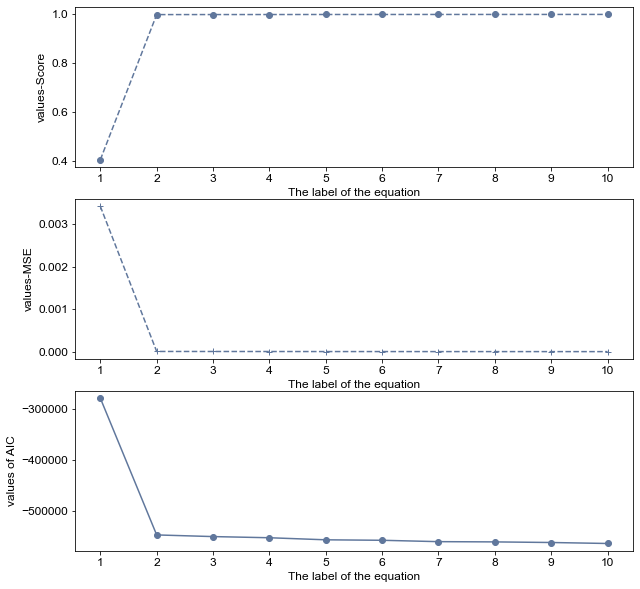

In [155]:
# Visualization
Index = np.arange(1,imp_no_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

In [156]:
from sklearn.linear_model import LinearRegression

In [157]:
bestMe_excit = bestMe.drop(bestMe[bestMe['T']>0].index)
xi = bestMe_excit['x1'].values
xj = bestMe_excit['x2'].values
# xi = bestMe['x1'].values
# xj = bestMe['x2'].values
Matrix = ElementaryFunctions_Matrix(xi,xj)
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
#goal = bestMe_excit['e0'].values.reshape(-1,1)
goal = bestMe_excit['e0'].values.reshape(-1,1)
goal = pd.DataFrame(data = goal, columns =['e0'])
X = Matrix.copy()
y = goal.copy()

In [158]:
Xfind = pd.concat([X['sigmoidxj101'],X['xisigmoidxj101']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['e0']

In [159]:
model_linear = LinearRegression(fit_intercept=False)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_

In [160]:
print(a)

[-0.22863775 -0.14750558]


In [123]:
best_selfDyn = selfDyn_over_time[-1]
best_selfDyn = pd.DataFrame(best_selfDyn)

In [124]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)

In [125]:
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = False, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [126]:
goal = best_selfDyn['s2'].values
goal = pd.DataFrame(data = goal, columns =['s2'])

In [127]:
X = self_matrix.copy()
y = goal.copy()

In [128]:
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [129]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=10000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


0.9991356348750987
Best threshold: 0.001


In [130]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)

In [131]:
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)

Elementary functions discovered by Phase 1 with constant.
x2x2       -0.003409
x2x3        0.005393
x1x1x1x2    0.007773
x3x3       -0.011652
x1x1x1x1    0.038315
x1x2       -0.046899
x1         -0.053589
x1x1x1     -0.141689
x2         -0.990605
x1x1       -4.841788
constant    1.074328
dtype: float64


In [132]:
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = self_matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = self_matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])

6.202194868798472e-09 16.04722345947744 277555.5841432003 constant
0.21047959853600606 12.669610386688442 253924.62430069112 x1x1
0.9973157787282411 0.04307429882975379 -314476.8774593752 x2
0.9973578635155343 0.04239895483962497 -316055.1567056886 x1x1x1
0.9973807809076728 0.04203119432459084 -316924.32143662014 x1
0.9973847727296522 0.041967136664878925 -317074.8427340681 x1x2
0.9975724036853933 0.038956180771511306 -324517.78344916686 x1x1x1x1
0.9984223297623541 0.02531722700589292 -367611.02056384075 x3x3
0.9986249418178945 0.02206586605488651 -381354.33868660853 x1x1x1x2
0.9988461529147399 0.01851604213007656 -398891.7780482122 x2x3
0.9994334549465216 0.00909147512941614 -470019.81034949777 x2x2


/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error 

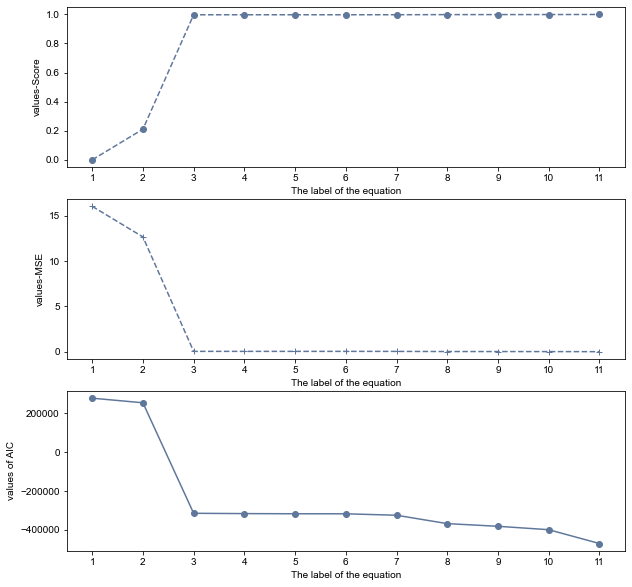

In [133]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()

In [135]:
TimeSeries = best_selfDyn.iloc[:,0:3].values
TimeSeries = TimeSeries.reshape(-1,Dimension)
self_matrix = self_ElementaryFunctions_Matrix(TimeSeries, Dimension, 4, PolynomialIndex = True, TrigonometricIndex = False, \
ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False)
self_matrix = self_matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
goal = best_selfDyn['s2'].values
goal = pd.DataFrame(data = goal, columns =['s2'])
X = self_matrix.copy()
y = goal.copy()

In [136]:
Xfind = pd.concat([X['x2'],X['x1x1']],axis=1)#pd.concat([v1,v2],axis=1)
yfind = y['s2']

In [137]:
model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(Xfind,yfind)
a = model_linear.coef_

In [138]:
a

array([-0.99498259, -4.98009929])

In [139]:
model_linear.intercept_

0.9953270402565534

In [140]:
model_linear.score(Xfind,yfind)

0.9973157787282411

In [141]:
#torch.save(ogn, 'HR_N20_intensity01_t500_net.pth')